# Projet de fin de majeure : Super résolution
#### Johanna Dubos, Zoé Ducourau & Dimitri Szezurek
---

In [3]:
# Librairies
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import shutil

#### Image considérée (échelle de Monoyer)

Taille de l'image : Hauteur =  943 || Largeur =  768


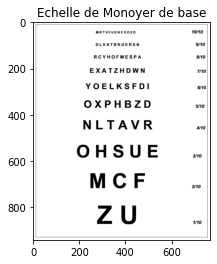

In [4]:
filename = 'Echelle-Monoyer.png'

IMAGE_nb = cv2.imread(filename,0)
[H,W] = IMAGE_nb.shape

print("Taille de l'image : Hauteur = ", H, "|| Largeur = " , W)

plt.imshow(IMAGE_nb,cmap='gray')
plt.title('Echelle de Monoyer de base')
plt.show()

#### Création de la BDD avec N images (déformées, floutées, sous-échantillonées & bruitées)

In [5]:
if os.path.exists('BDD'):
    shutil.rmtree('BDD')

os.makedirs('BDD')

In [6]:
N = 10 # Nb d'images dans la BDD

for i in range (0,N):

    if i == 0:
        img_translated = cv2.warpAffine(IMAGE_nb, np.float32([[1,0,W/2],[0,1,H/2]]),(2*W,2*H)) # Translation
        M = cv2.getRotationMatrix2D((W/2,H/2), 0, 1) # Matrice de rotation
        img_rotated = cv2.warpAffine(img_translated,M,(2*W,2*H)) # Rotation
        img_blurred = cv2.blur(img_rotated,(5,5))   # Floutage 
        img_downsampled = cv2.pyrDown(cv2.pyrDown(img_blurred)) # Sous-échantillonnage /4

        # Ajout d'un bruit gaussien 
        gauss = np.random.normal(0,5,img_downsampled.shape)
        gauss = gauss.reshape(img_downsampled.shape)
        img_noisy = img_downsampled + gauss

        plt.imsave("BDD/imageBR_0.png",img_noisy,cmap='gray')

    else:
        img_translated = cv2.warpAffine(IMAGE_nb, np.float32([[1,0,np.random.randint(W/2)],[0,1,np.random.randint(H/2)]]),(2*W,2*H)) # Translation
        angle=np.random.randint(-10,10)
        M = cv2.getRotationMatrix2D((W/2,H/2), angle, 1) # Matrice de rotation
        img_rotated = cv2.warpAffine(img_translated,M,(2*W,2*H)) # Rotation
        img_blurred = cv2.blur(img_rotated,(5,5))   # Floutage 
        img_downsampled = cv2.pyrDown(cv2.pyrDown(img_blurred)) # Sous-échantillonnage /4

        # Ajout d'un bruit gaussien 
        gauss = np.random.normal(0,5,img_downsampled.shape)
        gauss = gauss.reshape(img_downsampled.shape)
        img_noisy = img_downsampled + gauss

        plt.imsave("BDD/imageBR_"+str(i)+".png",img_noisy,cmap='gray')

#### Différentes étapes :
- Recalage/estimation du mouvement des images BR
- Estimation du flou des images BR
- Sélection d'un a priori convenable
- Estimation d'une image HR


## Recalage des images de la BDD

In [7]:
if os.path.exists('BDD_recalee'):
    shutil.rmtree('BDD_recalee')
    
os.makedirs('BDD_recalee')

In [8]:
def recaler_images (N):
    img_droite = cv2.imread('BDD/imageBR_0.png')
    plt.imsave("BDD_recalee/imageBR_recalee_0.png",img_droite,cmap='gray')

    LM_transfo = list() # Liste avec les matrices de transformation des différentes images recalées

    for i in range (1,N):

        img_a_recaler = cv2.imread("BDD/imageBR_"+str(i)+".png")

        orb = cv2.ORB_create()
        kp1, des1 = orb.detectAndCompute(img_a_recaler, None)
        kp2, des2 = orb.detectAndCompute(img_droite, None)

        # # Affichage des points d'intérêt
        # base_keypoints = cv2.drawKeypoints(img_droite, kp2, color=(0, 0, 255), flags=0, outImage=img_droite)
        # test_keypoints = cv2.drawKeypoints(img_a_recaler, kp1, color=(0, 0, 255), flags=0, outImage=img_a_recaler)

        # Création de l'objet BFMatcher et recherche des correspondances
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)

        # Tri des correspondances selon leur distance
        matches = sorted(matches, key=lambda x: x.distance)

        # Extraction des meilleures correspondances
        num_matches = 1000
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:num_matches]]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:num_matches]]).reshape(-1, 1, 2)

        # Calcul de l'homographie et recale de l'image 1 sur l'image 2
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        recaled_img = cv2.warpPerspective(img_a_recaler, M, (img_droite.shape[1], img_droite.shape[0]))

        LM_transfo.append(M)
        
        plt.imsave("BDD_recalee/imageBR_recalee_"+str(i)+".png",recaled_img,cmap='gray')
    
    # # Vérification du recalage
    # print(LM_transfo)

    # # Exemple de recalage
    # plt.figure()
    # plt.subplot(141)
    # plt.imshow(img_droite)
    # plt.title('Référence')

    # plt.subplot(142)
    # plt.imshow(img_a_recaler)
    # plt.title("À recaler")

    # plt.subplot(143)
    # plt.imshow(recaled_img)
    # plt.title("Recalée")

    # plt.subplot(144)
    # plt.imshow(img_droite-recaled_img)
    # plt.title("Diff")

    # plt.show()
    return(LM_transfo)


In [10]:
LM_transfo = recaler_images(N)

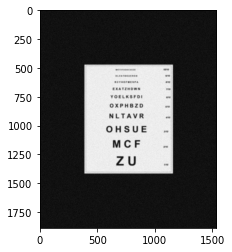

In [25]:
# paramètres
beta = 0.7
l = 0.3
observations = []
for k in range(N):
    observations.append(cv2.imread('BDD/imageBR_' + str(k) + '.png'))

# initialisation
width_LR = int(observations[0].shape[1])
height_LR = int(observations[0].shape[0])
dim_HR = (4*width_LR, 4*height_LR)
estim = cv2.resize(observations[0], dim_HR, interpolation = cv2.INTER_CUBIC)
plt.imshow(estim)

# iterations
# for n in range(10):

    # gradient
    # pour chaque observation:
        # appliquer la transfo (rotation + translation) à l'estimation
        # convoluer PSF (bruit blanc gaussien)
        # down sampling 
        # soustaire l'observation
        # appliquer l'opérateur signe (resultat reste >0)
        # up sampling
        # convoluer par T(PSF)
        # appliquer transfo inverse


    # regularisation
    # pour l de -P à P
        # pour m de 0 à P
            # si l+m >= 0
            # appliquer shift Sx à l'estimation
            # appliquer shift Sy 
            # soustraire le résultat à l'estimation 
            # appliquer opérateur signe
            # garder résultat intermédiaire
            # appliquer anti shift Sx
            # appliquer anti shift Sy
            # soustraire au résultat intermédiaire
            #multiplier par alpha ^{|m|+|l|}

    # new_estim = estim - beta*step
    # estim = new_estim


